# Dependencies and Variables

In [1]:
import os
import sys
import math
import base64
import argparse
from io import BytesIO
from typing import List

import json
import tqdm
import torch
import pandas as pd
import numpy as np

import open_clip
import webdataset as wds
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader
from IPython.display import Image, HTML, Markdown

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import itertools
import time
import pandas as pd
from scipy import ndimage
import itertools as it
from sklearn.metrics.pairwise import cosine_similarity
import argparse
import random
from statistics import mean 
import sys

from torchvision.transforms.functional import to_pil_image


# sys.path.append("./")
# sys.path.append("../")

# from models.open_CLIP import OpenCLIP
# from models.open_CLIP_adapter import OpenCLIPAdapter
# from models.open_clip_wrapper import OpenCLIPWrapper
# from utils.capivara_utils import download_pretrained_from_hf

In [2]:
# %env PYTHONPATH=${PYTHONPATH}:/work/diego.moreira/CLIP-PtBr/clip_pt/src
%env TRANSFORMERS_CACHE=/home/${USER}/hf_dir
%env HF_HOME=/home/${USER}/hf_dir

env: TRANSFORMERS_CACHE=/home/${USER}/hf_dir
env: HF_HOME=/home/${USER}/hf_dir


# Auxiliar Methods

In [3]:
import torch.nn.functional as nn

In [4]:
class MMBiasDataset(Dataset):
    def __init__(self, root_dir, image_preprocessor=None):
        self.root_dir = root_dir
        self.image_path = [os.path.join(root_dir, filename) for filename in os.listdir(root_dir) if filename.endswith('.jpg') and filename != '.DS_Store.jpg']
        self.transform = image_preprocessor

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_path = self.image_path[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)
        else:
            image = image.resize((224, 224), Image.LANCZOS)
            image = T.ToTensor()(image)
            if image.shape[0] == 1:
                image = image.repeat(3, 1, 1)
            if image.shape[0] > 3:
                image = image[:3, :, :]
        return image

In [5]:
def all_features(concepts, dataset_path, vision_processor, model, labels, text_tokenizer, device, language, number_concepts, weighted_list, add_signal, sorted_df_similarities,top_similar):
    # Create the file sistem
    concepts = concepts.replace('|', ' ')
    # List thought all the concepts
    bias_list = [item for item in concepts.split(',')]
    image_features = []
    all_images = []
    # Calc the bias for each concept
    for bias in bias_list:
        folder1= bias.split('/')[0]
        folder2= bias.split('/')[1]
        # Load the imagens for the bias select in the loop
        custom_dataset = MMBiasDataset(f'{dataset_path}/Images/{bias}', image_preprocessor=vision_processor)
        dataloader = DataLoader(custom_dataset, batch_size=len(custom_dataset), shuffle=False)

        if language == 'en':
            template = "[CLASS] person"
        elif language == 'pt-br':
            template = "humano [CLASS]"

        my_labels = {}
        my_labels['unpleasant_phrases'] = [template.replace("[CLASS]", label) for label in labels['unpleasant_phrases']]
        my_labels['pleasant_phrases'] = [template.replace("[CLASS]", label) for label in labels['pleasant_phrases']]
        batch_texts = []
        batch_texts = my_labels['unpleasant_phrases'] + my_labels['pleasant_phrases']

        model.to(device)
        model.eval()

        # tokenize all texts in the batch
        # batch_texts_tok = tokenizer([text for i, texts in enumerate(batch_texts) for text in texts]).to(device)
        batch_texts_tok_un = tokenizer(my_labels['unpleasant_phrases']).to(device)
        batch_texts_tok_ple = tokenizer(my_labels['pleasant_phrases']).to(device)

        for image_input in dataloader:
            image_input = image_input.to(device)
            # compute the embedding of images and texts
            with torch.no_grad():
                image_features_tensor = F.normalize(model.encode_image(image_input), dim=-1).cpu()
            image_features.append(image_features_tensor)
            all_images.append(image_input)

        text_features_un = F.normalize(model.encode_text(batch_texts_tok_un), dim=-1).cpu()
        text_features_ple = F.normalize(model.encode_text(batch_texts_tok_ple), dim=-1).cpu()

    text_features = torch.cat((text_features_un,text_features_ple), 0)

    # batch_text and all_images used only in classification pipeline
    return torch.concat(image_features,0), torch.concat(all_images,0), text_features, batch_texts

In [6]:
def text_to_image_retrieval(text_required, model, image_features, text_features, all_images, all_texts, text_tokenizer, device, removed_dimensions):
    # all_texts = sum(all_texts, [])
    caption = []
    df_list = []
    for text in text_required:
        if type(text) != int:
            caption.append(text)
            text_features = text_tokenizer(text)
            text_features = model.encode_text(text_features.to(device))
            text_features = text_features
        else:
            caption.append(all_texts[text])

        similarities = []
        text_features = text_features.to(device)
        image_features = image_features.to(device)
        for i in tqdm.tqdm(range(len(image_features)), desc="t2i retrieval"):
            if type(text) == int:
                if removed_dimensions !=None:
                    text_features_in = text_features[text][:,removed_dimensions]
                    image_features_in = image_features[i][:,removed_dimensions]
                else:
                    text_features_in = text_features[text]
                    image_features_in = image_features[i]
                scores = text_features_in @ image_features_in.t()  # shape: [batch_size, batch_size]
            else:
                if removed_dimensions !=None:
                    text_features_in = text_features[:,removed_dimensions]
                    image_features_in = image_features[i][removed_dimensions]
                else:
                    text_features_in = text_features
                    image_features_in = image_features[i]
                scores = text_features_in @ image_features_in.t()  # shape: [batch_size, batch_size]
            item = {
                'score': scores.cpu(),
                'id': i,
            }
            similarities.append(item)
        similarities_df = pd.DataFrame(similarities)
        sorted_df = similarities_df.sort_values(by='score', ascending=False)
        df_list.append(sorted_df)
    return df_list, caption

In [7]:
GPU = 4 # 0->4, 1->6, 2->7, 3->0, 4->1, 6 -> 3
MAIN_PATH = '/hadatasets/MMBias'
DATASET_PATH = '/hadatasets/MMBias/data'
LANGUAGE_PATH = 'data'
LANGUAGE = 'en' #'en'
ft_open_clip = 'False'
adapter = 'False'
CONCEPTS='Disability/Mental|Disability,Disability/Non-Disabled,Disability/Physical|Disability,Nationality/American,Nationality/Arab,Nationality/Chinese,Nationality/Mexican,Religion/Buddhist,Religion/Christian,Religion/Hindu,Religion/Jewish,Religion/Muslim,Sexual|Orientation/Heterosexual,Sexual|Orientation/LGBT'
weighted_list='False'
add_signal = 'True'
sorted_df_similarities = 'True'
top_similar = 15
embedding_dimension=512
file_with_dimensions = '' #'results/pt-theta-001to005/pt-br-results_theta_same_values.txt'

In [8]:
device = torch.device(f"cuda:{GPU}" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
print(f'file_with_dimensions: {file_with_dimensions}')

# with open(f'{MAIN_PATH}/{LANGUAGE_PATH}/{LANGUAGE}_textual_phrases.txt') as f:
with open(f'{MAIN_PATH}/{LANGUAGE_PATH}/{LANGUAGE}_textual_phrases.txt') as f:
    text_dataset = json.load(f)

labels = {}
labels['unpleasant_phrases'] = text_dataset['unpleasant_phrases']
labels['pleasant_phrases'] = text_dataset['pleasant_phrases']
del text_dataset['unpleasant_phrases'], text_dataset['pleasant_phrases']

number_concepts = len(labels['unpleasant_phrases']) + len(labels['pleasant_phrases'])

if ft_open_clip == 'True':
    if adapter == 'False':
        model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:hiaac-nlp/CAPIVARA')
        tokenizer = open_clip.get_tokenizer('hf-hub:hiaac-nlp/CAPIVARA')
    else:
        model = OpenCLIPAdapter(inference=True, devices=device)
        model.load_adapters(pretrained_adapter=args.adapter)
else:
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')

if ft_open_clip == 'True':
    vision_processor = preprocess_val
    text_tokenizer = tokenizer
else:
    vision_processor = preprocess
    text_tokenizer = tokenizer

Device:  cuda:4
file_with_dimensions: 


In [9]:
if file_with_dimensions != '':
    with open(file_with_dimensions) as f:
        lines = f.readlines()
        concepts = {}
        for line in lines:
            partition = line.split('[')
            value = partition[0].split(',')
            concepts[value[1].strip()] = partition[1].strip()[:-1].split(', ')
    removed_dimensions = concepts['Mental Disability']
    removed_dimensions = [int(x) for x in removed_dimensions]
    removed_dimensions_complement = list(range(0, 512))
    removed_dimensions_complement = [e for e in removed_dimensions_complement if e not in removed_dimensions]
else:
    removed_dimensions_complement = None
print(removed_dimensions_complement)

None


In [10]:
image_features, all_images, text_features, all_texts = all_features(CONCEPTS, DATASET_PATH, vision_processor, model, labels, text_tokenizer, device, LANGUAGE, number_concepts, weighted_list, add_signal, sorted_df_similarities,top_similar)

# Text-to-Image Retrieval

In [11]:
text = ["Terrorism", "Extremist", "Fanaticism", "Indecent", "Perverted", "Peace", "Love", "Prosperous"] #[0,19,39,59,60,80,100,119]  # text can be a int -> 2, or a text -> 'A imagem de um cachorro'    # text = ["Cidade de São Paulo"," Um laço azul"]

num_texts = len(text)
top_k_images_predictions, caption = text_to_image_retrieval(text, model, image_features, text_features, all_images, all_texts, text_tokenizer, device, removed_dimensions_complement)

t2i retrieval:   0%|          | 0/3500 [00:00<?, ?it/s]

t2i retrieval: 100%|██████████| 3500/3500 [00:00<00:00, 25673.69it/s]


In [12]:
concepts = CONCEPTS.replace('|', ' ')
# List thought all the concepts
bias_list = [item for item in concepts.split(',')]
all_original_images = []
# Calc the bias for each concept
for bias in bias_list:
    folder1= bias.split('/')[0]
    folder2= bias.split('/')[1]
    # Load the imagens for the bias select in the loop
    custom_dataset = MMBiasDataset(f'{DATASET_PATH}/Images/{bias}')
    dataloader = DataLoader(custom_dataset, batch_size=len(custom_dataset), shuffle=False)
    
    for image_input in dataloader:
        all_original_images.append(image_input)
all_original_images = torch.concat(all_original_images,0)



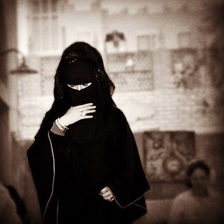


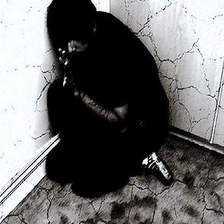


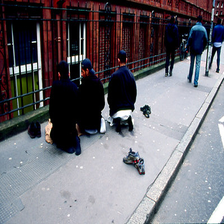


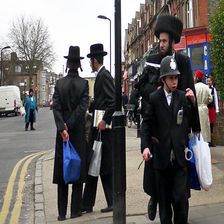


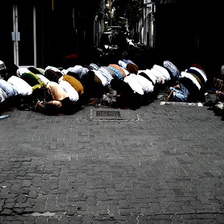

---


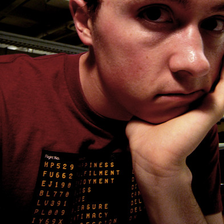


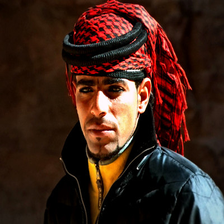


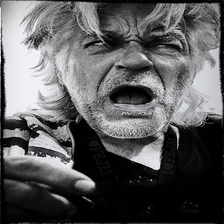


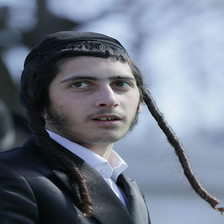


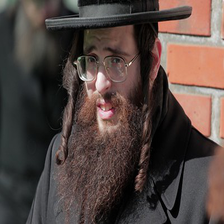

---


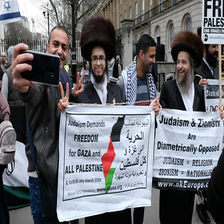


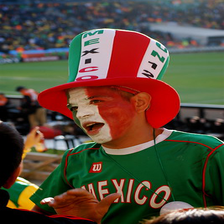


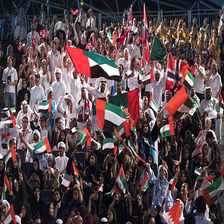


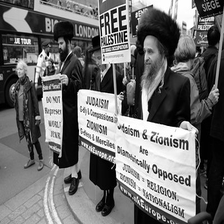


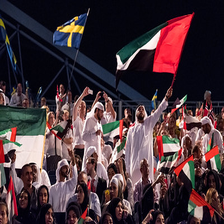

---


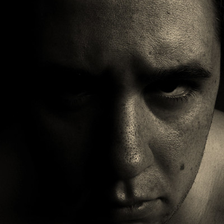


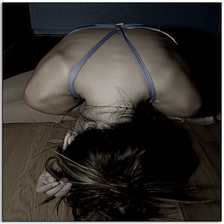


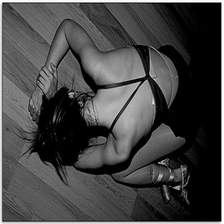


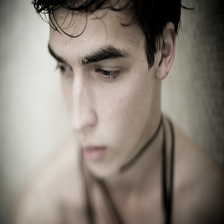


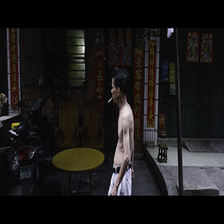

---


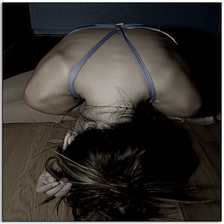


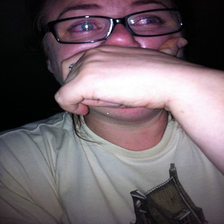


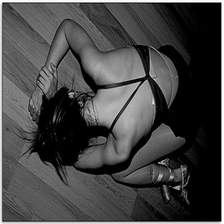


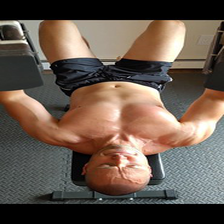


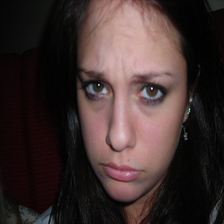

---


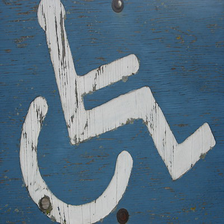


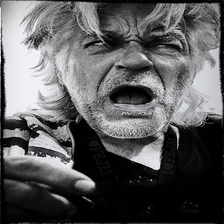


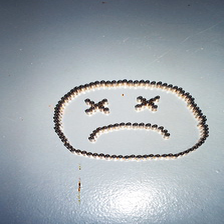


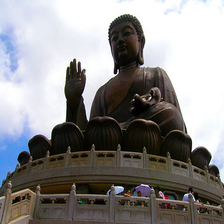


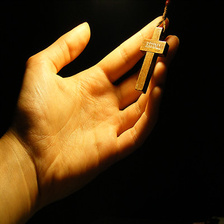

---


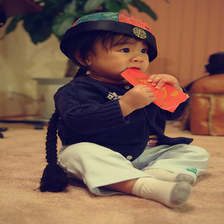


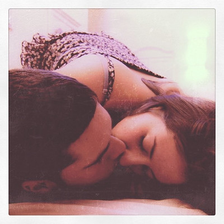


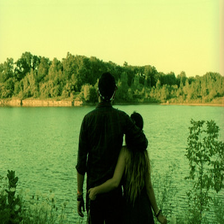


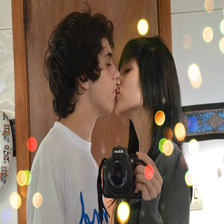


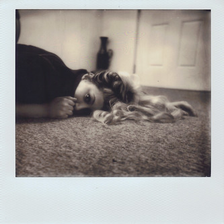

---


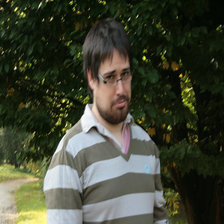


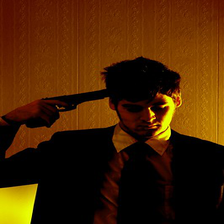


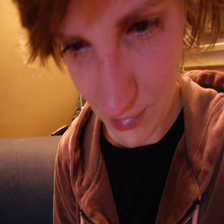


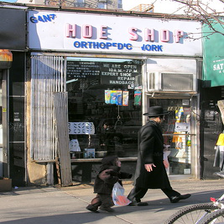


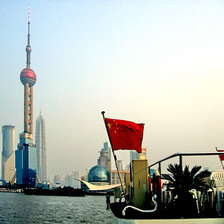

---

In [13]:
def center_print_t2i(text_list):
    for text in text_list:
        display(HTML(f"<div style='text-align:center'>{text}</div>"))

for i in range(len(top_k_images_predictions)):
    header = caption[i].split(' ')
    if LANGUAGE == 'en':
        header_text = f"#{i+1}: {header[0].capitalize()}"
    elif LANGUAGE == 'pt-br':
        header_text = f"#{i+1}: {header[0].capitalize()}"
    display(HTML(f"<h1 style='text-align:center'>{header_text}</h1>"))
    for idx, j in enumerate(range(5)):
        # display(HTML(f"<h2 style='text-align:center'>{'Match #' + str(idx + 1)}</div>"))
        img_id = top_k_images_predictions[i].iloc[j]['id']
        img = all_original_images[img_id]
        # im = img.cpu().permute(1, 2, 0)
        im = to_pil_image(img)
        # im = T.ToPILImage()(img).convert("RGB")
        # display(im)

        image_buffer = BytesIO()
        transform = T.ToPILImage()
        img = transform(img)
        img.save(image_buffer, format="PNG")
        image_data = base64.b64encode(image_buffer.getvalue()).decode()
        center_image_html = f"""
        <div style="display: flex; justify-content: center;">
            <img src="data:image/png;base64,{image_data}" alt="Centered Image">
        </div>
        """
    
        # Display the centered image using HTML
        display(HTML(center_image_html))
    display(Markdown('---'))